**Projet réalisé en binôme par:**
- Samy Khlifi
- Wissal Belhorma

In [546]:
# Toutes les importation nécéssaires seront ici.
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
import sympy as sp
from tabulate import tabulate

# ***1) Processus de Markov et modélisation du système:***

On va modéliser le système en utilisant un : 
$$ 
Closed\ Migration\ Process 
$$


Cette modélisation est approprié car notre systeme




L'espace d'état du processus de markov est :  

$$
E = \{ n = (n_1, n_2, n_3, n_4) \mid \sum_{j=1}^{4} n_j = N \}
$$
 avec N le nombre de trotinettes.

Chaque état est écrit comme vecteur $ n = (n_1, n_2, n_3, n_4) $ avec $n_i $ est le nombre de trotinettes dans la colonie i.


Ici , on considère 4 colonnies representantes les 4 états de notre chaine de Markov :

- **colonie 1** : trotinettes non utilisées

- **colonie 2** : trotinettes utilisées
- **colonie 3** : trotinettes en panne
- **colonie 4** : trotinettes déchargées


Pour deux differentes colonies j et k on définit l'opérateur $ T_{jk} $ comme indiqué dans le cours (Livre_colonies) .

Reste à définir les taux pour chaque transition d'un état d'espace à autre.
D'après le cours , les taux de transitions ont la forme 
$q(n, T_{jk}(n)) = \lambda_{jk} \times \phi_j (n_j)$    avec   $\phi(0) = 0 $.

On définit ici les taux de transitions pertinents dans notre processus ,tout autre taux  $λ_{ij} $ non mentionné est égal à 0 par impossibilité de transition (On a suppposé qu'une trottinette non utilisée ne peut pas  tomber en panne ou avoir une batterie vide, et qu'une trottinettte maintenue par un prestataire ou un technicien redevient disponible (non utilisée)):



- $\phi_1(n_1)$: $ \mathbb{1}_{n_1 > 0} $ avec $n_1$  le nombre de trotinettes non utilisées
- $λ_{12} =  λ $
- $\phi_2(n_2) = n_2 $: le nombre de trotinettes utilisées
- $λ_{21} = \frac{1}{t_{trajet}}  (1 - p_{panne} - p_{vide})$
- $λ_{23} =  \frac{1}{t_{trajet}}  p_{panne}$
- $λ_{24} =  \frac{1}{t_{trajet}}  p_{vide}$
- $\phi_3(n_3)= n_3$: le nombre de trotinettes en panne
- $λ_{31} =  \frac{1}{t_{réparation} + t_{intervention}}$
- $\phi_4(n_4)= n_4$: le nombre de trotinettes déchargées

- $λ_{41} = \phi_4 \frac{1}{t_{recharge} + t_{intervention}}$

### Justifications :
- Une trotinette en cours d'utilisation peut tomber en panne avec probabilité $p_{panne}$, se décharger avec probabilité $p_{vide}$, et vue que ces deux évènements sont incompatibles, la probabilité qu'une trottinettte aboutit son trajet sans problème est $P=(1 - p_{panne} - p_{vide})$
- On a consideré $\phi_1(n_1)$: $ \mathbb{1}_{n_1 > 0} $ , car le nombre de trotinettes disponible n'a aucune influence sur le taux de transition de l'état 1 à 2, seule la disponibilité d'au moins une trotinettte importe, d'oû notre choix de la fonction indicatrice de disponibilite d'au moins une trottinette.

- Pour $ i = 2,3,4 $ on a considéré $\phi_2(n_i) = n_i$,  ceci revient au fait que le nombres de trotinettes présentes dans ces états a une influence directe  sur le les taux de transitions. 
En effet, si on considère l'état 4 à l'état 1, on n'a besoin que d'une seule trotinette maintenue par un technicien pour avoir une transition de l'état 4 à 1, donc si on a k trottinettes en panne, le temps avant la prochaine transition de 4 --> 1  est le minimum de k lois exponentielles indépendantes de meme paramètre $\lambda_{41}$, elle est donc de paramètre  $ k*\lambda_{41}$. (La même justification s'applique au deux autres cas)


On peut résumer notre modèle avec le diagramme de transitions suivant:

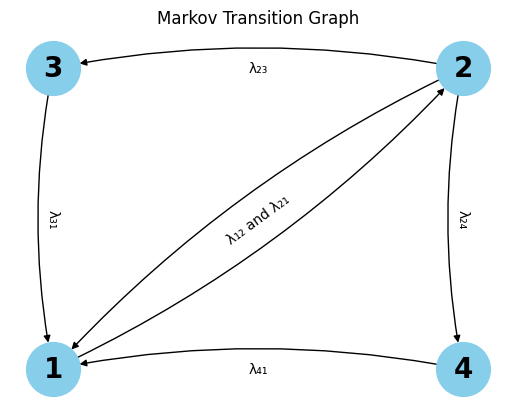

In [547]:
#This is just code meant to visualise the Markov transition graph and can be ignored

lambda_rate_1_to_2 = sp.Symbol("\u03bb₁₂")
lambda_rate_2_to_1 = sp.Symbol("\u03bb₁₂ and \u03bb₂₁")
x2_rate = sp.Symbol('\u03bb₂₃')
x3_rate = sp.Symbol('\u03bb₂₄')
y1_rate = sp.Symbol('\u03bb₃₁')
y2_rate = sp.Symbol('\u03bb₄₁')

G = nx.DiGraph()


G.add_node("1")
G.add_node("2")
G.add_node("3")
G.add_node("4")


G.add_edge("1", "2", weight=lambda_rate_1_to_2)
G.add_edge("2", "1", weight=lambda_rate_2_to_1)
G.add_edge("2", "3", weight=x2_rate)
G.add_edge("2", "4", weight=x3_rate)
G.add_edge("3", "1", weight=y1_rate)
G.add_edge("4", "1", weight=y2_rate)


pos = {"1": (1, 1), "2": (2, 2), "3": (1, 2), "4": (2, 1)}

fig, ax = plt.subplots()

labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=20, font_weight="bold", ax=ax, 
        arrows=True, connectionstyle="arc3,rad=0.1")  # using curved edges
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Markov Transition Graph")
plt.show()




Ici l'état $ i $ représente la colonnie $ i $.

# ***2) Calibration du modèle:***

In [548]:
# Valeurs numériques des paramètres donnés

N = 100
lambda_ = 0.1
t_trajet = 5
p_panne = 0.01
p_vide = 0.1
t_intervention = 30
t_recharge = 240
t_reparation = 720

In [549]:
# Valeurs des paramètres de transitions:

lambda_rate_1_to_2 = lambda_ 
lambda_rate_2_to_1 = (1/t_trajet)*(1-p_panne-p_vide)
lambda_rate_2_to_4 = (1/t_trajet)* p_vide
lambda_rate_2_to_3 = (1/t_trajet)* p_panne 
lambda_rate_4_to_1 = 1/(t_intervention + t_recharge)
lambda_rate_3_to_1 = 1/(t_reparation + t_intervention)


# ***3) Probabilité stationnaire théorique:***


On résoud les équations de traffic qui donnent le système linéaire suivant 


$\alpha_{1}λ_{12} = \alpha_{2}λ_{21} + \alpha_{3}λ_{31} + \alpha_{4}λ_{41} $


$\alpha_{2}λ_{21} = \alpha_{1}λ_{12}  $

$\alpha_{3}λ_{31} = \alpha_{2}λ_{23}  $

$\alpha_{4}λ_{41} = \alpha_{2}λ_{24}  $

$ \alpha_{1} + \alpha_{2} + \alpha_{3} + \alpha_{4} = 1 $

Notons  
$$
\mathbf{\alpha} = \begin{pmatrix} \alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \alpha_4 \end{pmatrix}  \   et  \ B = \begin{pmatrix}
\lambda_{12} & - \lambda_{21} & - \lambda_{31} & -\lambda_{41} \\
- \lambda_{12} & \lambda_{21} + \lambda_{23}+ \lambda_{24} & 0 & 0 \\
0 & -\lambda_{23} & \lambda_{31} & 0 \\
0 & -\lambda_{24} & 0 & \lambda_{41} \\
\end{pmatrix}
$$

On trouve le système linéaire suivant 
$ \ B\alpha = 0 $. $B$ étant non inversible , le système admet alors une solution qu'il faut normaliser


La probabilité stationnaire théorique est donnée alors par l'expression :
$$
\pi(n)=G_{N}^{-1} \alpha_1^{n_1} \frac{\alpha_2^{n_2}}{n_2!} \frac{\alpha_3^{n_3}}{n_3!} \frac{\alpha_4^{n_4}}{n_4!} , \quad n \in E
$$
avec $G_{N}$ une constante de normalisation tel que la somme de la distribution est égale à 1

On résout donc numériquement notre système pour trouver les valeurs des $\alpha_{i}$, et donc conséquamment trouver la probabilité stationnaire.

In [550]:
B = np.array([[lambda_rate_1_to_2, -lambda_rate_2_to_1, -lambda_rate_3_to_1 ,-lambda_rate_4_to_1],
              [-lambda_rate_1_to_2,lambda_rate_2_to_1 + lambda_rate_2_to_3 + lambda_rate_2_to_4, 0 ,0],
              [0,-lambda_rate_2_to_3,lambda_rate_3_to_1,0],
              [lambda_rate_2_to_4,0,lambda_rate_2_to_4,lambda_rate_2_to_4 + lambda_rate_4_to_1]] )
alphas = np.zeros(4)
alphas = np.linalg.solve(B, np.array([0,0,0,lambda_rate_2_to_4]))

print("Alphas: ", alphas)
print(np.sum(alphas)) # On vérifit ici que la somme est bien égale à 1.

Alphas:  [0.2020202  0.1010101  0.15151515 0.54545455]
1.0


## ***4) Simulation des trajectoires:***

D'abord on commence par definir certaines fonctions nécéssaires au fonctionnement de notre simulation.

In [551]:
# Cette fonction définit l'indicatrice sur l'événement n1>0    
def indicatrice(n):
    if n[0]>0:
        return 1
    else:
        return 0

In [552]:
# Cette fonction jouera le role de la matrice de transition Q, le paramètre n représente l'état courant (c'est donc une liste à quatre éléments).
def Q(n):
    return([[0,indicatrice(n)*lambda_rate_1_to_2,0,0]
            ,[lambda_rate_2_to_1*n[1],0,lambda_rate_2_to_3*n[1],lambda_rate_2_to_4*n[1]],
            [lambda_rate_3_to_1*n[2],0,0,0],
            [lambda_rate_4_to_1*n[3],0,0,0]])



In [553]:
# Cette fonction servira à effectuer une mmise à jour à l'état courant n après une transition d'un état i à un état j.
def update(n,i,j):
    n[j-1]+=1
    n[i-1]-=1 # on applique le changement à i-1 et j-1 car les listes sont indéxées à partir de 0 et non 1.
    
    return n

La transition à effectuer sera choisie aléatoirement selon la distribution de probabilité donnée par ($\frac{Q_{12}}{\sum_{i,j} Q_{ij}}$,$\frac{Q_{21}}{\sum_{i,j} Q_{ij}}$,$\frac{Q_{23}}{\sum_{i,j} Q_{ij}}$,$\frac{Q_{24}}{\sum_{i,j} Q_{ij}}$,$\frac{Q_{31}}{\sum_{i,j} Q_{ij}}$,$\frac{Q_{41}}{\sum_{i,j} Q_{ij}}$)

In [554]:
# Cette fonction construit la distribution de probabilité mentionée en haut.
def distribution(n):
    sum=Q(n)[0][1]+Q(n)[1][0]+Q(n)[1][2]+Q(n)[1][3]+Q(n)[3][0]+Q(n)[2][0]
    return[Q(n)[0][1]/sum,Q(n)[1][0]/sum,Q(n)[1][2]/sum,Q(n)[1][3]/sum,Q(n)[2][0]/sum,Q(n)[3][0]/sum]

In [555]:
# Cette fonction choisit et effectue la transition selon la distribution de probablité mentionnée en haut.

def transition(n):
    next_state=np.random.choice([1,2,3,4,5,6],p=distribution(n)) #les 6 éléments de la liste représentent les 6 transitions possibles
    match next_state:
        case 1:
            update(n,1,2)
        case 2:
            update(n,2,1)
        case 3:
            update(n,2,3)
        case 4:
            update(n,2,4)
        case 5:
            update(n,3,1)
        case 6:
            update(n,4,1)
    
    return n

Maintenant qu'on a construit les outils nécéssaires, on va simuler notre modèle sur 100 heures, et on visualisera le nombre de trotinetttes dans chaque état.

Pour avoir une transition, il suffit qu'un état i transitionne vers l'état j, la variable T qui determine les temps de transition est donc le minimum de 6 (transitions possibles) lois exponentielles :

$$T \sim \min\left(\exp(-Q_{12}), \exp(-Q_{21}), ..., \exp(-Q_{41})\right)$$

Et vue **l'indépendances** entre ces variables, T suit la loi :

$$T \sim \text{Exp}\left(\sum_{i,j} -Q_{ij}\right)$$


In [556]:
def trajectoire(n_initial,T_final):
    T=[0] # cette variable contiendra les temps de transitions
    N=[n_initial] # cette variable contiendra tous les états et nous sera utile pour suivre l'évolution de notre processus
    while T[-1]<T_final:
        T+=[T[-1] + np.random.exponential(1/(Q(N[-1])[0][1]+Q(N[-1])[1][0]+Q(N[-1])[1][2]+Q(N[-1])[1][3]+Q(N[-1])[3][0]+Q(N[-1])[2][0]))]
        x=transition(N[-1])
        #print(x)
        N.append(x.copy())
        #print(N)
       
      
    return T,N

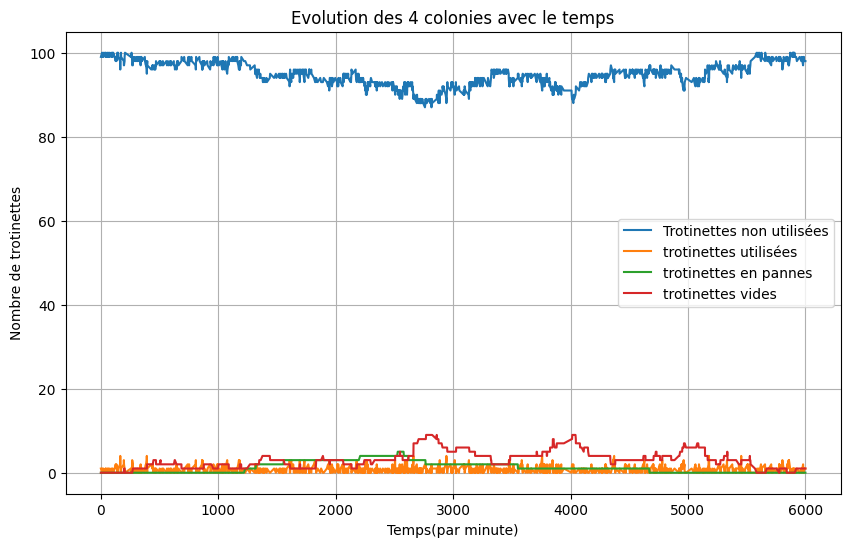

In [557]:
T,L = trajectoire([100,0,0,0],6000)

#Tracé des courbes d'évolution des colonies
variable_1 = [item[0] for item in L]
variable_2 = [item[1] for item in L]
variable_3 = [item[2] for item in L]
variable_4 = [item[3] for item in L]

plt.figure(figsize=(10, 6))
plt.plot(T, variable_1, label='Trotinettes non utilisées')
plt.plot(T, variable_2, label='trotinettes utilisées')
plt.plot(T, variable_3, label='trotinettes en pannes')
plt.plot(T, variable_4, label='trotinettes vides')
plt.xlabel('Temps(par minute)')
plt.ylabel('Nombre de trotinettes')
plt.title('Evolution des 4 colonies avec le temps')
plt.legend()
plt.grid(True)
plt.show()

On remarque que pour les valeurs de paramètres données, le nombre de trotinettes disponibles restent constamment supérieur à 80.

## ***5) Validation de simulation:***

On utilise la méthode de Monte Carlo qui permet d'approcher $\pi(x) = P(X=x) ≈ \frac{1}{N} \sum_{i=1}^{N} I(X_i = x) $   avec  $ \ X $ le processus de markov qui  modélise dans nos simulation l'évolution du nombre de trotinettes dans nos  colonies $  n = (n_1, n_2, n_3, n_4). $ 

On trouve alors un estimateur de probabilité stationnaire qu'on approche à partir de nos observations dans la simulation , on le compare à la probabilité stationnaire théorique .


On trouve la probabilité stationnaire en calculant les différents états possibles pour ***$N = 2$*** trotinettes , et évaluant la formule théorique de $\pi(n)$ trouvée dans la question 3 pour ces différents états.

In [558]:
Y,Q = trajectoire([2,0,0,0],300000)

In [559]:
#Cette fonction calcule les états possibles pour une valeur de N
def états_possibles(N):
    possible_values=[i for i in range(N+1)]
    l = [[k, j, p, s] for k in possible_values for j in possible_values for p in possible_values for s in possible_values if (k + j + p + s == N)]
    return l

In [560]:
# On calcule ici la formule théorique de la probabilité stationnaire,non normmalisée
def compute_pi(n , alphas):
    n1=n[0]
    n2=n[1]
    n3=n[2]
    n4=n[3]
    l3 =math.factorial(n3)
    l2 =math.factorial(n2)
    l4 =math.factorial(n4)
    pi=(alphas[0]**n1)*(alphas[1]**n2)*(alphas[2]**n3)*(alphas[3]**n4)/(l2*l3*l4)
    
    return pi

In [561]:
# Normalisation des probabilités obtenues par la fonction précédente
def normalisation_pi(probabilities):
    total=sum(probabilities)
    normalized=[p/total for p in probabilities]
    return normalized   

In [562]:
# fonction indicatrice pour vérifier égalité à un état
def indicatrice_1(n, état):
    if n == état:
        return 1
    else:
        return 0


In [563]:
# Estimateur Monte-Carlo
def Monte_Carlo_estimation(n,état):
    M=len(n)
    x=0
    for i in range(M):
        x+=indicatrice_1(n[i],état)
    return x/M



On ne dispose pas des valeurs exactes de variances, on construit donc des estimateurs de variance empirique

In [564]:
# Estimation variance empirique
def variance(n,état):
    M=len(n)
    x=0
    mc=Monte_Carlo_estimation(n,état)
    for i in range(M):
        x+=(indicatrice_1(n[i],état)-mc)**2
    return x/(M-1)

Dans le code ci-dessous, on estime que le régime stationnaire est atteint lors des 10% dernières états d'où notre code:    ##k= int(len(n_total)  et ## n = n_total[k:]   

In [565]:
# On construit ici les intervalles de confiance nécessaire pour la validation de notre simulation
def intervalle_confiance(n_total,états_possibles,béta):
    k= int(len(n_total) * 0.9)  
    n = n_total[k:]  
    A=[]
    for x in états_possibles:
        A+=[[Monte_Carlo_estimation(n,x)-béta*np.sqrt(variance(n,x)/len(n)),Monte_Carlo_estimation(n,x)+béta*np.sqrt(variance(n,x)/len(n))]]
    return A

On essaie ici de valider notre modèle en vérifiant si nos valeurs théoriques de probabilités stationnaires se situent bien dans nos intervalles de confiance

In [566]:
confidence_intervals = intervalle_confiance(Q, états_possibles(2), 1.96)


alphas = [0.2020202, 0.1010101, 0.15151515, 0.54545455]

probabilities = []
for states in états_possibles(2):
    probabilities.append(compute_pi(states, alphas))
stationary_proba = normalisation_pi(probabilities)

table_data = []
for interval, prob in zip(confidence_intervals, stationary_proba):
    table_data.append([f"{interval[0]:.4f} - {interval[1]:.4f}", f"{prob:.4f}"])

print(tabulate(table_data, headers=["Confidence Intervals", "Probability"]))


Confidence Intervals      Probability
----------------------  -------------
0.0176 - 0.0297                0.2859
0.0073 - 0.0159                0.1588
-0.0004 - 0.0012               0.0221
0.2538 - 0.2893                0.1059
0.0434 - 0.0611                0.0294
0.0407 - 0.0580                0.0098
0.2562 - 0.2919                0.2117
0.0445 - 0.0625                0.0588
0.1426 - 0.1717                0.0392
0.0942 - 0.1189                0.0784


On remarque que plusieurs valeurs ne sont pas à l'intérieur de l'interval de confiance. On peut expliquer ceci par le nombre bas de trottinettes considérées $(N=2)$. 



### ***Une seconde méthode d'estimer la probabilité stationnaire?***

#### On pourra exécuter la simulation ,ensuite, en examinant les dernières états obtenus, par exemple les dernies 10 %, nous pouvons éstimer l'état stationnaire. En calculant la durée totale du régime stationnaire, qui consiste en la somme des durées passées dans chaque état pendant cette période, nous obtenons une base pour évaluer les probabilités stationnaires: Diviser la durée passée dans chaque état par la durée totale du régime stationnaire pourrait donc nous donner  les probabilités stationnaires respectives pour chaque état.

## ***6) Et si le nombre de prestataires et techniciens était fini?***

Une transition de l'état ***trotinette vide*** à l'état ***trotinette non utilisée*** nécessite qu'une seule trotinette parmi les $n_4$ trotineettes  vides soit chargées.
Mais ici, on n'attend pas  seulement qu'une trotinette vide soit chargée, mais plutôt qu'une trotinette vide avec un préstataire présent soit chargée. 
Donc si le nombre de prestataires disponibles est supérieur au nombre de trotinettes déchargées, il suffit d'attendre qu'une trotinette déchargée quelconque soit chargée (puisqu'elles  disposent tous d'un préstataire) , donc $n_4$ trotinettes. 
Mais  si le nombre de trotinettes vides dépasse le nombre de prestataires, on attend qu'une trotinette vide et avec un prestataire soit chargée, donc $n_p$ trotinetttes.
On conclut donc que le changemement à effectuer  à notre modèle est le suivant:   $$\phi_4(n_4)= min(n_4,n_p)$$ 

La même règle (et justification) s'applique au cas des trotinetttes en panne, avec : $$\phi_3(n_3)= min(n_3,n_t)$$ 

## ***7)Et si une trotinette pouvait devenir irréparable?***

On distingue deux cas selon notre compréhension:

- Si la trotinettte devient irréparable directement après son utilisation, alors les changements à effectuer à notre modèle sont les suivants:

 > On ajoute une cinquième colonie, à notre modèle, appelée **trotinettes irréparables**, et qui sera le 5 ème état. (l'espace d'état est donc mis à jour bien sur)

 > On ajoute une transition de l'état 2 (**trotinettes utilisée**) à l'état 5, avec le paramètre suivant $λ_{25} =  \frac{1}{t_{trajet}}  p_{i} $  ($\phi_2$ reste inchangée)

 >On met à jour le taux de la transition de l'état 2 à  l'état 1 (**trotinettes non utilisée**), qui devient maintenant égal à:  $λ_{21} = \frac{1}{t_{trajet}}  (1 - p_{panne} - p_{vide}-p_{i})$

 >L'espace d'état 5 est ici un état isolant, autrement dit, il n'y a aucune transition sortante de cet état vers un autre état.


- Si par contre la trotinettte est éstimée être irreparable par technicien après qu'elle soit tombé en panne, et ceci après un temps d'intervention $t_{intervention}$ (ce qui nous semble plus logique), alors les changements à effectuer à notre modèle sont les suivants:

 > On ajoute une cinquième colonie, à notre modèle, appelée **trotinettes irréparables**, et qui sera le 5 ème état. (l'espace d'état est donc mis à jour bien sur)

 > On ajoute une transition de l'état 3 (**trotinettes en panne**) à l'état 5, avec le paramètre suivant $λ_{35} =  \frac{1}{t_{intervention}}  p_{i} $  ($\phi_3$ reste inchangée)

 >On met à jour le taux de transition de l'état 3 à l'état 1, qui devient maintenant égal à:  $λ_{31} = \frac{1}{t_{réparation}+t_{intervention}}  (1 -p_{i})$
 
  >L'espace d'état 5 est ici un état isolant, autrement dit, il n'y a aucune transition sortante de cet état vers un autre état.





$$**Fin**$$